## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, GRU, Flatten, MaxPool2D, MaxPool1D
from tensorflow.keras.layers import PReLU, Dropout, Lambda, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from scipy.signal import stft

from music_generator.basic.random import generate_dataset
from music_generator.basic.signalproc import SamplingInfo
from music_generator.synthesizer.instrument import make_lead_instrument, make_accomp_instrument
from music_generator.musical.timing import Tempo, Duration
from music_generator.musical.scales import GenericScale
from music_generator.basic.signalproc import mix_at
from music_generator.analysis import preprocessing
from music_generator.musical.chords import ChordInScaleDefinition
from music_generator.musical.notes import Note

from music_generator.musical import scales
from music_generator.musical import timing

import numpy as np
from multiprocessing import Pool
from functools import partial

import matplotlib.pyplot as plt
from IPython.display import Audio
%matplotlib inline
import matplotlib

from scipy.io.wavfile import read
import pandas as pd

from music_generator.basic import random
from music_generator.synthesizer import instrument
from music_generator.analysis import plots

## Goal

We are going to generate some music and detect which notes were being played

```
Model: Wave in -> Sequence of notes out
```

## Method

1. Generate random music
2. Chop the wave data into small batches of a 1/10th of a second
3. Use Fourier to go to a frequency representation of the sound
4. For each of those batches, predict which note is being played
5. Mold the data into a multiclass classification problem
6. Each class corresponds to a note being played
7. Train a model with a Gated Recurrent Unit as classifier

## Parameters

In [2]:
sr = 44100
stft_window_size = 4096
sampling_info = SamplingInfo(sr)

## Generate & render the data

In [3]:
scale = scales.major_scale('C')
tempo = timing.Tempo(120)
signature = timing.Signature(4, 4)
inst = instrument.make_lead_instrument(sampling_info)

In [4]:
def generate_dataset(scale, tempo, signature, inst, n_measures=128, n_notes_per_measure=16):
    trk_lead = random.generate_lead_track(scale, 
                                          tempo, 
                                          signature, 
                                          n_measures=n_measures, 
                                          n_notes_per_measure=n_notes_per_measure)
    audio = inst.generate_track(trk_lead)

    df_targets = pd.DataFrame()
    df_targets['offset'] = [x.offset.seconds for x in trk_lead.generate_notes()]
    df_targets['duration'] = [x.duration.seconds for x in trk_lead.generate_notes()]
    df_targets['end'] = df_targets['offset'] + df_targets['duration']
    df_targets['note'] = [str(x.note) for x in trk_lead.generate_notes()]
    df_targets = df_targets.groupby(['offset', 'end', 'note']).size().unstack('note').fillna(0).astype(int)
    df_targets = df_targets.reset_index()
    
    return audio, trk_lead, df_targets

In [5]:
audio, trk_lead, df_targets = generate_dataset(scale, tempo, signature, inst)

## Multiclass note targets 

In [6]:
df_targets.head(4)

note,offset,end,A4,A5,B4,B5,C4,C5,D4,D5,E4,E5,F4,F5,G4,G5
0,0.000,0.125,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0.125,0.250,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0.250,0.375,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.375,0.500,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [7]:
note_cols = [str(x) for x in 
             pd.Series([x.note for x in trk_lead.generate_notes()]).sort_values().drop_duplicates()]
', '.join(note_cols)

'C4, D4, E4, F4, G4, A4, B4, C5, D5, E5, F5, G5, A5, B5'

## Fourier analysis of the waveform

(0, 3000)

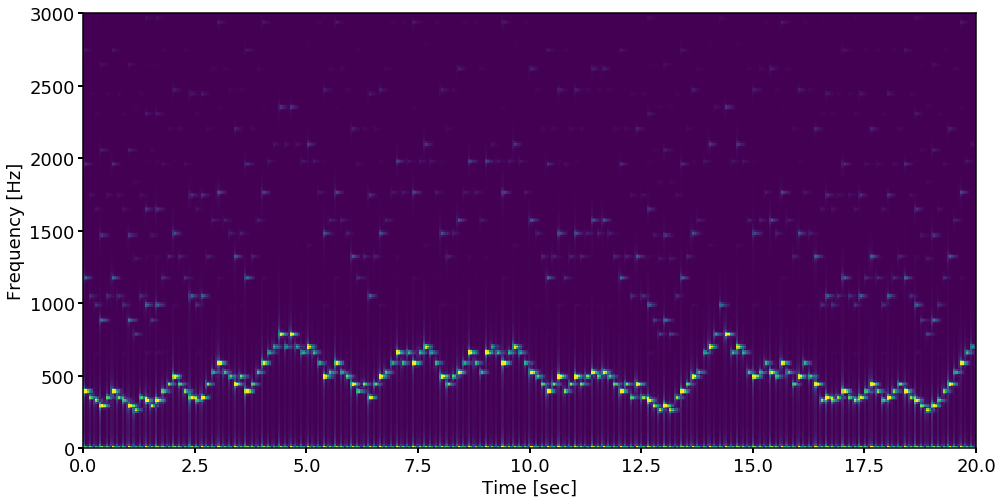

In [8]:
plots.set_style()
plots.stft_plot(audio, sr, vmax=0.05)
plt.xlim([0, 20])
plt.ylim([0, 3000])

## Apply Fourier and collect the right targets

In [9]:
def clip_incomplete_batch(arr, batch_size):
    return arr[0:(len(arr) // batch_size) * batch_size]

In [10]:
def preprocess(audio, df_targets, n_steps, batch_size):
    
    # Apply Fourier on the waveform
    stft_frequencies, stft_timesteps, stft_transformed = stft(audio, sr, nperseg=stft_window_size)

    X_train = np.abs(stft_transformed)
    X_train = X_train.T
    X_train = clip_incomplete_batch(X_train, n_steps)
    X_train = X_train.reshape(X_train.shape[0] // n_steps, n_steps, X_train.shape[1])
    
    # Based on time t, we collect the targets
    y_train = np.array([df_targets[(df_targets.offset <= t) & 
                                   (t < df_targets.end)][note_cols].sum().values for t in stft_timesteps])
    
    # Clipping or zero-padding is needed in order for the dimensions to be OK for training
    X_train = clip_incomplete_batch(X_train, batch_size)
    y_train = clip_incomplete_batch(y_train, batch_size)
    
    return X_train, y_train, stft_frequencies

In [11]:
n_steps = 1
batch_size = 32

X_train, y_train, stft_frequencies = preprocess(audio, df_targets, n_steps, batch_size)

## Why Fourier is helping

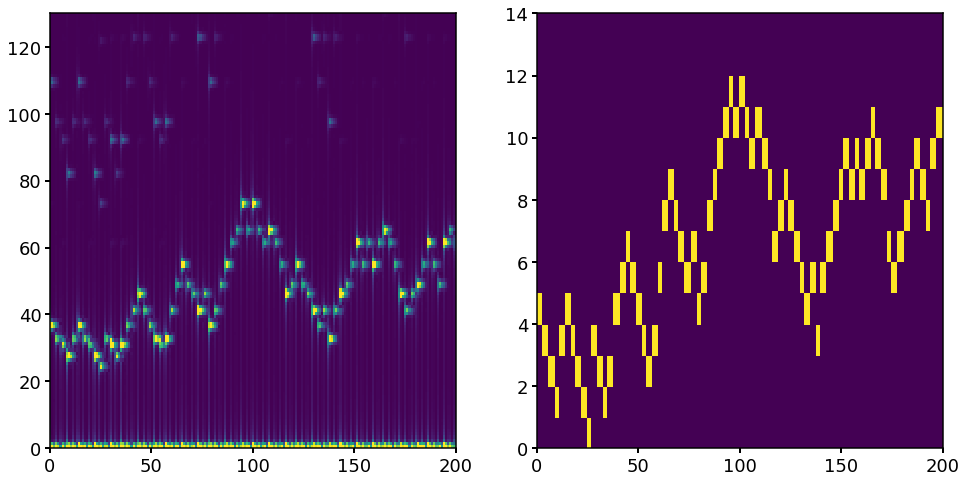

In [12]:
sel = np.arange(0, 200)

fig, ax = plt.subplots(1, 2)

plt.sca(ax[0])
sel = np.arange(0, 200)
plt.pcolormesh(X_train[sel, 0, 0:130].T, vmin=0, vmax=0.05)

plt.sca(ax[1])
sel = np.arange(0, 200)
plt.pcolormesh(y_train[sel].T, vmin=0, vmax=1)

## Setting up the GRU

### Layer Design

* The hidden state is 14 dimensional, which is also the number of different notes that can be played
* The number of timesteps is set to only 1, but the RNN is stateful
* Each timestep corresponds to a Fourier spectrum, which is a vertical slice in the FFT plot above
* The `input_dim` parameter corresponds to the number of frequencies in FFT (=2048 + 1, in this case)
* Note that in the time-domain this corresponds to 4096 samples, i.e. ~0.1 seconds
* For each of the timesteps a note is being predicted

In [15]:
n_channels = stft_frequencies.shape[0]
inp = Input(shape=(n_steps, n_channels)) # , batch_shape=(batch_size,n_steps, n_channels))

gru = GRU(14)
dense = Dense(len(note_cols), activation='sigmoid')

x = inp
x = gru(x)
out = dense(x)

model = Model(inp, out)
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 2049)]         0         
_________________________________________________________________
unified_gru_1 (UnifiedGRU)   (None, 14)                86730     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                210       
Total params: 86,940
Trainable params: 86,940
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(X_train, y_train, batch_size=batch_size, epochs=16, verbose=1)

Epoch 1/16
22048/22048 [==============================] - 2s 69us/sample - loss: 2.5237 - accuracy: 0.2281
Epoch 2/16
22048/22048 [==============================] - 1s 60us/sample - loss: 1.9732 - accuracy: 0.6772
Epoch 3/16
22048/22048 [==============================] - 1s 60us/sample - loss: 1.2401 - accuracy: 0.8071
Epoch 4/16
22048/22048 [==============================] - 1s 60us/sample - loss: 0.8770 - accuracy: 0.8512
Epoch 5/16
22048/22048 [==============================] - 1s 59us/sample - loss: 0.6862 - accuracy: 0.8741
Epoch 6/16
22048/22048 [==============================] - 1s 59us/sample - loss: 0.5723 - accuracy: 0.8838
Epoch 7/16
22048/22048 [==============================] - 1s 59us/sample - loss: 0.4976 - accuracy: 0.8905
Epoch 8/16
22048/22048 [==============================] - 1s 58us/sample - loss: 0.4450 - accuracy: 0.8935
Epoch 9/16
22048/22048 [==============================] - 1s 60us/sample - loss: 0.4044 - accuracy: 0.8975
Epoch 10/16
22048/22048 [============

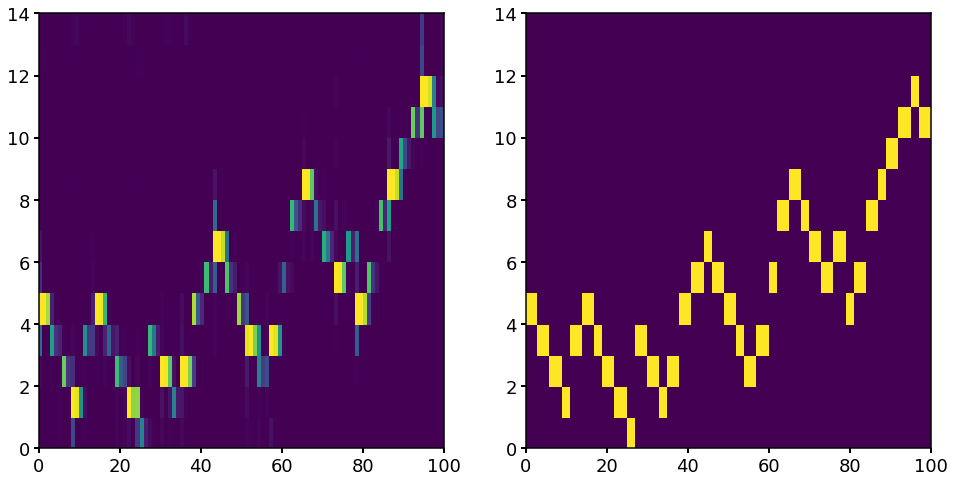

In [17]:
y_pred = model.predict(X_train, batch_size=batch_size)
fig, ax = plt.subplots(1, 2)
sel = np.arange(0, 100)

plt.sca(ax[0])
plt.pcolormesh(y_pred[sel].T, vmin=0, vmax=1)
plt.sca(ax[1])
plt.pcolormesh(y_train[sel].T, vmin=0, vmax=1)

If we continue training for one night we can get a very good performance on this data set.

## Test model

In [18]:
audio, trk_lead, df_targets = generate_dataset(scale, tempo, signature, inst)
X_test, y_test, stft_frequencies = preprocess(audio, df_targets, n_steps, batch_size)

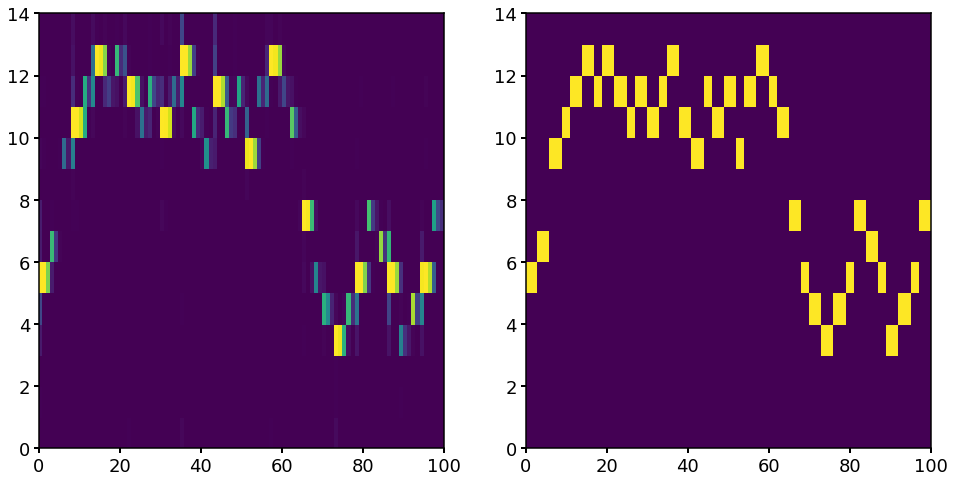

In [19]:
y_pred = model.predict(X_test, batch_size=batch_size)
fig, ax = plt.subplots(1, 2)
sel = np.arange(0, 100)

plt.sca(ax[0])
plt.pcolormesh(y_pred[sel].T, vmin=0, vmax=1)
plt.sca(ax[1])
plt.pcolormesh(y_test[sel].T, vmin=0, vmax=1)